1. INSTALL AND IMPORT LIBRARIES

In [1]:
!pip install plotly streamlit pyngrok pandas scikit-learn seaborn matplotlib wordcloud textblob

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.feature_selection import SelectKBest, f_classif

import re
from datetime import datetime
from textblob import TextBlob
from wordcloud import WordCloud


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 29.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 43.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 6.9 MB/s eta 0:00:00


2. DATA LOADING AND INITIAL EXPLORATION

In [4]:
df = pd.read_csv("Airplane_Crashes_and_Fatalities_Since_1908.csv")

In [5]:
print("Dataset Shape:", df.shape)
print("\nColumn Names:")
print(df.columns.tolist())
print("\nFirst 5 rows:")
df.head()

Dataset Shape: (5268, 13)

Column Names:
['Date', 'Time', 'Location', 'Operator', 'Flight #', 'Route', 'Type', 'Registration', 'cn/In', 'Aboard', 'Fatalities', 'Ground', 'Summary']

First 5 rows:


,Date,Time,Location,Operator,Flight #,Route,Type,Registration,cn/In,Aboard,Fatalities,Ground,Summary
0,09/17/1908,17:18,"Fort Myer, Virginia",Military - U.S. Army,NaN,Demonstration,Wright Flyer III,NaN,1,2.0,1.0,0.0,"During a demonstration flight, a U.S. Army fly..."
1,07/12/1912,06:30,"AtlantiCity, New Jersey",Military - U.S. Navy,NaN,Test flight,Dirigible,NaN,NaN,5.0,5.0,0.0,First U.S. dirigible Akron exploded just offsh...
2,08/06/1913,NaN,"Victoria, British Columbia, Canada",Private,-,NaN,Curtiss seaplane,NaN,NaN,1.0,1.0,0.0,The first fatal airplane accident in Canada oc...
3,09/09/1913,18:30,Over the North Sea,Military - German Navy,NaN,NaN,Zeppelin L-1 (airship),NaN,NaN,20.0,14.0,0.0,The airship flew into a thunderstorm and encou...
4,10/17/1913,10:30,"Near Johannisthal, Germany",Military - German Navy,NaN,NaN,Zeppelin L-2 (airship),NaN,NaN,30.0,30.0,0.0,Hydrogen gas which was being vented was sucked...


3. DATA PREPROCESSING AND FEATURE ENGINEERING

In [6]:
def preprocess_aviation_data(df):
    """
    Comprehensive data preprocessing for aviation dataset
    """
    # Make a copy
    data = df.copy()

    # Basic info
    print("Original dataset shape:", data.shape)
    print("Missing values:\n", data.isnull().sum())

    # Clean column names
    data.columns = data.columns.str.strip().str.lower().str.replace(' ', '_')

    # Handle date conversion
    if 'date' in data.columns:
        try:
            data['date'] = pd.to_datetime(data['date'], errors='coerce')
            data['year'] = data['date'].dt.year
            data['month'] = data['date'].dt.month
            data['day_of_week'] = data['date'].dt.dayofweek
        except:
            print("Date conversion failed - creating dummy dates")

    # Create risk categories based on fatalities
    if 'fatalities' in data.columns:
        data['fatalities'] = pd.to_numeric(data['fatalities'], errors='coerce').fillna(0)

        # Create risk levels
        conditions = [
            (data['fatalities'] == 0),
            (data['fatalities'] <= 5),
            (data['fatalities'] <= 20),
            (data['fatalities'] > 20)
        ]
        choices = ['No_Risk', 'Low_Risk', 'Medium_Risk', 'High_Risk']
        data['risk_level'] = np.select(conditions, choices, default='Unknown')

        # Binary classification target
        data['high_risk'] = (data['fatalities'] > 10).astype(int)

    # Process aboard column
    if 'aboard' in data.columns:
        data['aboard'] = pd.to_numeric(data['aboard'], errors='coerce').fillna(0)
        data['survival_rate'] = np.where(data['aboard'] > 0,
                                       1 - (data['fatalities'] / data['aboard']), 0)

    # Process operator information
    if 'operator' in data.columns:
        data['operator'] = data['operator'].fillna('Unknown')
        data['is_military'] = data['operator'].str.contains('Military|Army|Navy|Air Force',
                                                          case=False, na=False).astype(int)
        data['is_commercial'] = data['operator'].str.contains('Airlines|Airways|Air',
                                                            case=False, na=False).astype(int)

    # Process aircraft type
    if 'type' in data.columns:
        data['type'] = data['type'].fillna('Unknown')
        data['aircraft_category'] = data['type'].apply(categorize_aircraft)

    # Process location
    if 'location' in data.columns:
        data['location'] = data['location'].fillna('Unknown')
        data['country'] = data['location'].apply(extract_country)

    # Text analysis on summary
    if 'summary' in data.columns:
        data['summary'] = data['summary'].fillna('')
        data['summary_length'] = data['summary'].str.len()
        data['weather_mentioned'] = data['summary'].str.contains(
            'weather|storm|wind|fog|rain|snow', case=False, na=False).astype(int)
        data['mechanical_failure'] = data['summary'].str.contains(
            'engine|mechanical|failure|malfunction', case=False, na=False).astype(int)
        data['pilot_error'] = data['summary'].str.contains(
            'pilot|crew|human|error', case=False, na=False).astype(int)

    print("Processed dataset shape:", data.shape)
    return data

def categorize_aircraft(aircraft_type):
    """Categorize aircraft types"""
    if pd.isna(aircraft_type):
        return 'Unknown'

    aircraft_type = str(aircraft_type).lower()

    if any(word in aircraft_type for word in ['boeing', 'airbus', 'dc-', 'md-', 'l-']):
        return 'Commercial'
    elif any(word in aircraft_type for word in ['fighter', 'bomber', 'military']):
        return 'Military'
    elif any(word in aircraft_type for word in ['cessna', 'piper', 'beech']):
        return 'General_Aviation'
    elif any(word in aircraft_type for word in ['helicopter', 'chopper']):
        return 'Helicopter'
    else:
        return 'Other'

def extract_country(location):
    """Extract country from location string"""
    if pd.isna(location):
        return 'Unknown'

    # Simple country extraction (you can improve this)
    location = str(location)
    if ',' in location:
        return location.split(',')[-1].strip()
    return location

# Preprocess the data
processed_df = preprocess_aviation_data(df)


Original dataset shape: (5268, 13)
Missing values:
 Date               0
Time            2219
Location          20
Operator          18
Flight #        4199
Route           1707
Type              27
Registration     335
cn/In           1228
Aboard            22
Fatalities        12
Ground            22
Summary          390
dtype: int64
Processed dataset shape: (5268, 27)


4. EXPLORATORY DATA ANALYSIS

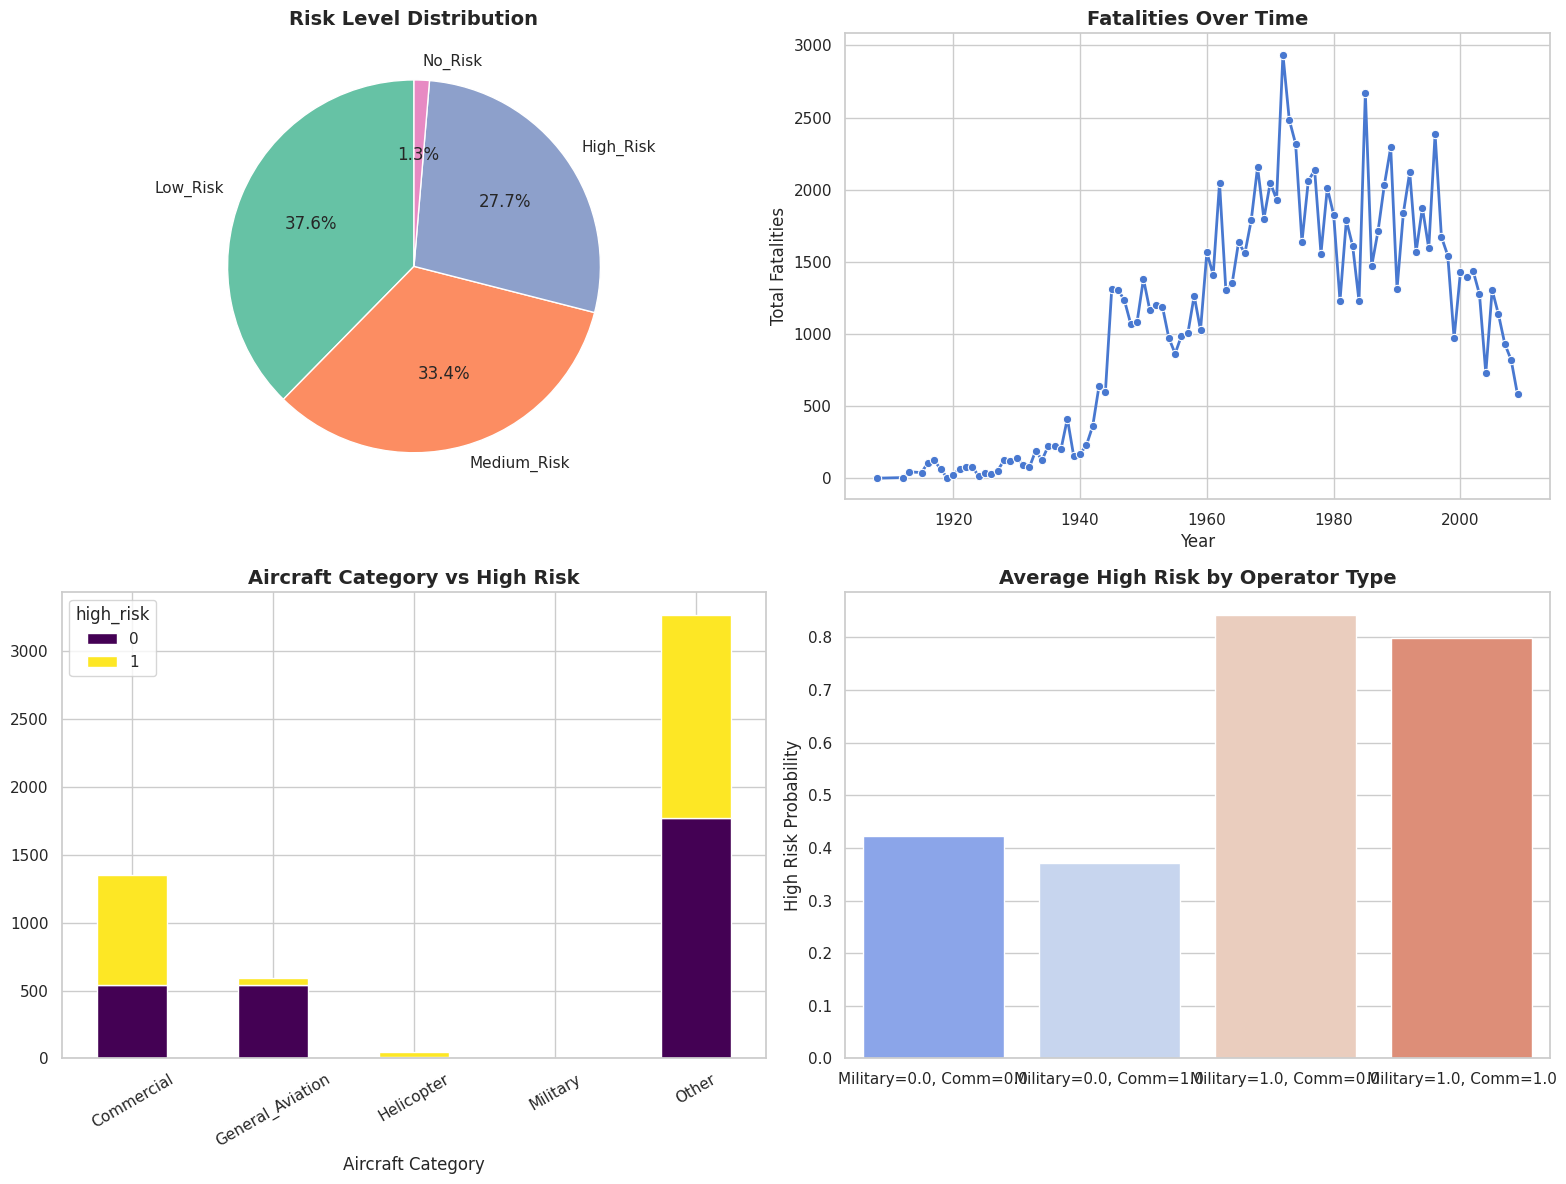

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import numpy as np
import pandas as pd

def create_eda_visualizations(data):
    """Enhanced EDA Visualizations with professional styling"""

    # Set style
    sns.set_theme(style="whitegrid", palette="muted")

    # Create subplot grid
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))

    # 1. Risk Level Distribution
    if 'risk_level' in data.columns:
        risk_counts = data['risk_level'].value_counts()
        axes[0, 0].pie(risk_counts.values, labels=risk_counts.index,
                       autopct='%1.1f%%', startangle=90, colors=sns.color_palette("Set2"))
        axes[0, 0].set_title('Risk Level Distribution', fontsize=14, fontweight="bold")

    # 2. Fatalities over time
    if 'year' in data.columns and 'fatalities' in data.columns:
        yearly_fatalities = data.groupby('year')['fatalities'].sum().reset_index()
        sns.lineplot(x='year', y='fatalities', data=yearly_fatalities,
                     marker='o', linewidth=2, ax=axes[0, 1])
        axes[0, 1].set_title('Fatalities Over Time', fontsize=14, fontweight="bold")
        axes[0, 1].set_xlabel('Year')
        axes[0, 1].set_ylabel('Total Fatalities')

    # 3. Aircraft category vs high risk
    if 'aircraft_category' in data.columns and 'high_risk' in data.columns:
        category_risk = pd.crosstab(data['aircraft_category'], data['high_risk'])
        category_risk.plot(kind='bar', stacked=True, colormap='viridis', ax=axes[1, 0])
        axes[1, 0].set_title('Aircraft Category vs High Risk', fontsize=14, fontweight="bold")
        axes[1, 0].set_xlabel('Aircraft Category')
        axes[1, 0].tick_params(axis='x', rotation=30)

    # 4. Operator type analysis
    if 'is_military' in data.columns and 'is_commercial' in data.columns and 'high_risk' in data.columns:
        operator_data = data.groupby(['is_military', 'is_commercial'])['high_risk'].mean().reset_index()
        operator_data['Operator'] = operator_data.apply(lambda row:
                                                       f"Military={row['is_military']}, Comm={row['is_commercial']}", axis=1)
        sns.barplot(x='Operator', y='high_risk', data=operator_data, ax=axes[1, 1], palette="coolwarm")
        axes[1, 1].set_title('Average High Risk by Operator Type', fontsize=14, fontweight="bold")
        axes[1, 1].set_xlabel('')
        axes[1, 1].set_ylabel('High Risk Probability')

    plt.tight_layout()
    plt.show()

    # ----------------- Interactive Plotly Visualizations -----------------

    # Timeline visualization
    if 'year' in data.columns and 'fatalities' in data.columns and 'risk_level' in data.columns:
        fig_timeline = px.scatter(data, x='year', y='fatalities',
                                  color='risk_level', size='aboard',
                                  hover_data=['operator', 'type'] if 'operator' in data.columns else None,
                                  title='Aviation Accidents Timeline',
                                  template="plotly_white")
        fig_timeline.show()

    # Risk factors correlation
    numeric_cols = data.select_dtypes(include=[np.number]).columns
    if len(numeric_cols) > 1:
        corr_matrix = data[numeric_cols].corr()
        fig_corr = px.imshow(corr_matrix,
                             text_auto=True,
                             color_continuous_scale="RdBu_r",
                             title='Risk Factors Correlation Matrix',
                             template="plotly_white")
        fig_corr.show()
create_eda_visualizations(processed_df)


5. FEATURE ENGINEERING FOR ML

In [13]:
def prepare_features_for_ml(data):
    """Prepare features for machine learning"""

    # Select relevant columns for modeling
    feature_columns = []

    # Numerical features
    numerical_features = ['year', 'month', 'day_of_week', 'aboard', 'summary_length']
    feature_columns.extend([col for col in numerical_features if col in data.columns])

    # Binary features
    binary_features = ['is_military', 'is_commercial', 'weather_mentioned',
                      'mechanical_failure', 'pilot_error']
    feature_columns.extend([col for col in binary_features if col in data.columns])

    # Categorical features (need encoding)
    categorical_features = ['aircraft_category', 'country']

    # Create feature matrix
    X = pd.DataFrame()

    # Add numerical and binary features
    for col in feature_columns:
        if col in data.columns:
            X[col] = data[col].fillna(0)

    # Encode categorical features
    label_encoders = {}
    for col in categorical_features:
        if col in data.columns:
            le = LabelEncoder()
            X[f'{col}_encoded'] = le.fit_transform(data[col].fillna('Unknown'))
            label_encoders[col] = le

    # Target variable
    if 'high_risk' in data.columns:
        y = data['high_risk']
    else:
        # Create a dummy target based on fatalities
        y = (data.get('fatalities', 0) > 5).astype(int)

    print(f"Feature matrix shape: {X.shape}")
    print(f"Target distribution:\n{y.value_counts()}")

    return X, y, label_encoders

X, y, encoders = prepare_features_for_ml(processed_df)

Feature matrix shape: (5268, 12)
Target distribution:
high_risk
0    2871
1    2397
Name: count, dtype: int64


6. MACHINE LEARNING MODEL DEVELOPMENT

Training Models...

Training Logistic Regression...
Accuracy: 0.7638
AUC Score: 0.8814

Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.89      0.80       574
           1       0.82      0.62      0.70       480

    accuracy                           0.76      1054
   macro avg       0.78      0.75      0.75      1054
weighted avg       0.77      0.76      0.76      1054


Training Random Forest...
Accuracy: 0.9032
AUC Score: 0.9484

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.84      0.90       574
           1       0.84      0.98      0.90       480

    accuracy                           0.90      1054
   macro avg       0.91      0.91      0.90      1054
weighted avg       0.91      0.90      0.90      1054


Training Gradient Boosting...
Accuracy: 0.9051
AUC Score: 0.9495

Classification Report:
              precision    recall  f1-score   support

    

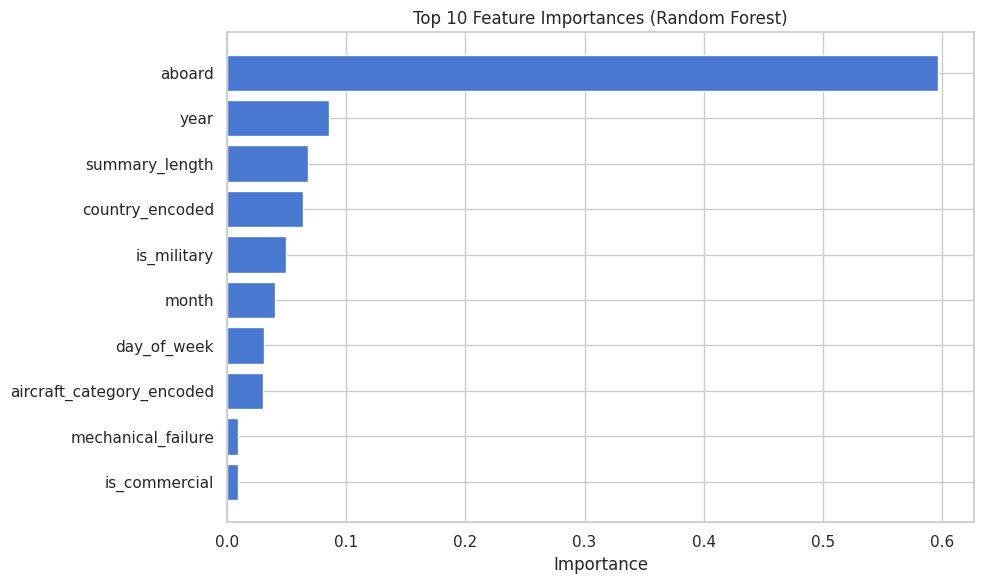

In [14]:
def train_risk_prediction_models(X, y):
    """Train multiple ML models for risk prediction"""

    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                        random_state=42, stratify=y)

    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Initialize models
    models = {
        'Logistic Regression': LogisticRegression(random_state=42),
        'Random Forest': RandomForestClassifier(random_state=42, n_estimators=100),
        'Gradient Boosting': GradientBoostingClassifier(random_state=42)
    }

    results = {}

    print("Training Models...")
    print("="*50)

    for name, model in models.items():
        print(f"\nTraining {name}...")

        # Use scaled data for Logistic Regression, original for tree-based models
        if name == 'Logistic Regression':
            model.fit(X_train_scaled, y_train)
            y_pred = model.predict(X_test_scaled)
            y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]
        else:
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            y_pred_proba = model.predict_proba(X_test)[:, 1]

        # Calculate metrics
        accuracy = model.score(X_test_scaled if name == 'Logistic Regression' else X_test, y_test)
        auc_score = roc_auc_score(y_test, y_pred_proba)

        results[name] = {
            'model': model,
            'accuracy': accuracy,
            'auc_score': auc_score,
            'predictions': y_pred,
            'probabilities': y_pred_proba
        }

        print(f"Accuracy: {accuracy:.4f}")
        print(f"AUC Score: {auc_score:.4f}")

        # Classification report
        print("\nClassification Report:")
        print(classification_report(y_test, y_pred))

    # Feature importance for Random Forest
    if 'Random Forest' in results:
        rf_model = results['Random Forest']['model']
        feature_importance = pd.DataFrame({
            'feature': X.columns,
            'importance': rf_model.feature_importances_
        }).sort_values('importance', ascending=False)

        print("\nTop 10 Most Important Features:")
        print(feature_importance.head(10))

        # Plot feature importance
        plt.figure(figsize=(10, 6))
        plt.barh(feature_importance.head(10)['feature'],
                feature_importance.head(10)['importance'])
        plt.title('Top 10 Feature Importances (Random Forest)')
        plt.xlabel('Importance')
        plt.gca().invert_yaxis()
        plt.tight_layout()
        plt.show()

    return results, X_test, y_test, scaler

# Train models
model_results, X_test, y_test, scaler = train_risk_prediction_models(X, y)


7. MODEL EVALUATION AND VISUALIZATION

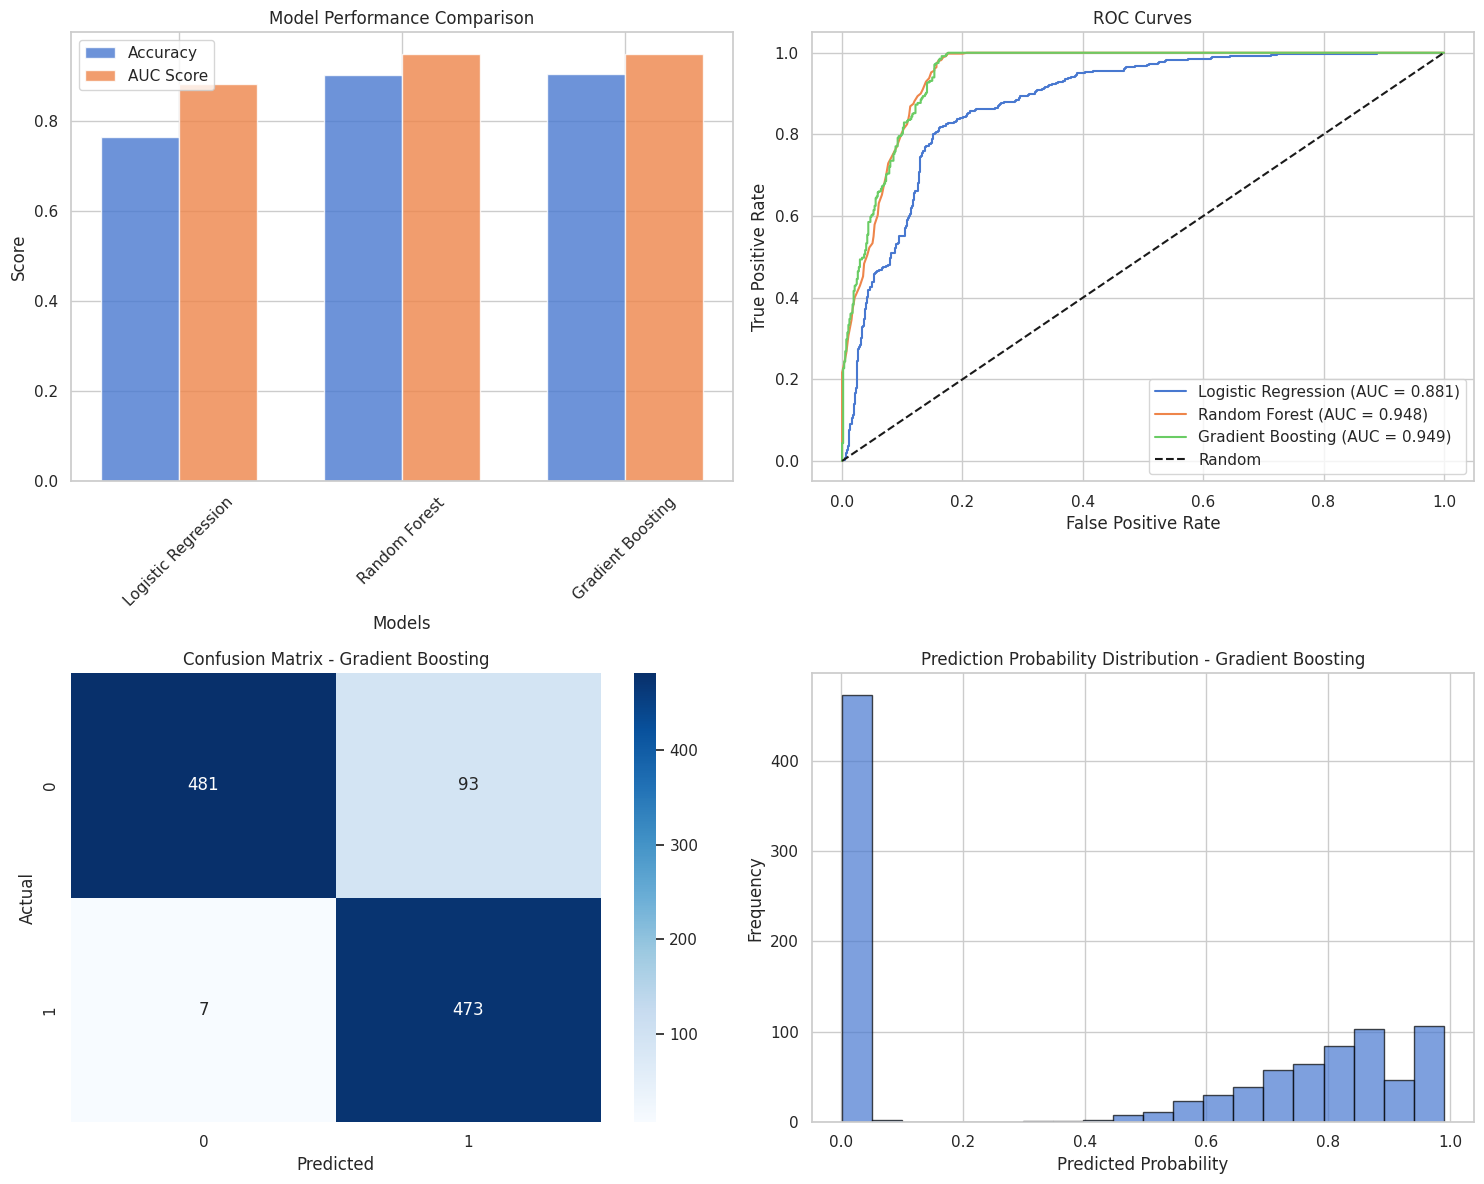


Best Model: Gradient Boosting
Best AUC Score: 0.9495


In [15]:
def create_model_evaluation_plots(results, X_test, y_test):
    """Create comprehensive model evaluation plots"""

    fig, axes = plt.subplots(2, 2, figsize=(15, 12))

    # Model comparison
    model_names = list(results.keys())
    accuracies = [results[name]['accuracy'] for name in model_names]
    auc_scores = [results[name]['auc_score'] for name in model_names]

    x = np.arange(len(model_names))
    width = 0.35

    axes[0,0].bar(x - width/2, accuracies, width, label='Accuracy', alpha=0.8)
    axes[0,0].bar(x + width/2, auc_scores, width, label='AUC Score', alpha=0.8)
    axes[0,0].set_xlabel('Models')
    axes[0,0].set_ylabel('Score')
    axes[0,0].set_title('Model Performance Comparison')
    axes[0,0].set_xticks(x)
    axes[0,0].set_xticklabels(model_names, rotation=45)
    axes[0,0].legend()

    # ROC Curves
    for name in model_names:
        y_pred_proba = results[name]['probabilities']
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        auc_score = results[name]['auc_score']
        axes[0,1].plot(fpr, tpr, label=f'{name} (AUC = {auc_score:.3f})')

    axes[0,1].plot([0, 1], [0, 1], 'k--', label='Random')
    axes[0,1].set_xlabel('False Positive Rate')
    axes[0,1].set_ylabel('True Positive Rate')
    axes[0,1].set_title('ROC Curves')
    axes[0,1].legend()

    # Confusion Matrix for best model
    best_model_name = max(results.keys(), key=lambda x: results[x]['auc_score'])
    best_predictions = results[best_model_name]['predictions']

    cm = confusion_matrix(y_test, best_predictions)
    sns.heatmap(cm, annot=True, fmt='d', ax=axes[1,0], cmap='Blues')
    axes[1,0].set_title(f'Confusion Matrix - {best_model_name}')
    axes[1,0].set_xlabel('Predicted')
    axes[1,0].set_ylabel('Actual')

    # Prediction distribution
    axes[1,1].hist(results[best_model_name]['probabilities'], bins=20, alpha=0.7, edgecolor='black')
    axes[1,1].set_xlabel('Predicted Probability')
    axes[1,1].set_ylabel('Frequency')
    axes[1,1].set_title(f'Prediction Probability Distribution - {best_model_name}')

    plt.tight_layout()
    plt.show()

    print(f"\nBest Model: {best_model_name}")
    print(f"Best AUC Score: {results[best_model_name]['auc_score']:.4f}")

# Create evaluation plots
create_model_evaluation_plots(model_results, X_test, y_test)

8. SAVE MODELS AND RESULTS

In [16]:
import joblib

# Save the best model
best_model_name = max(model_results.keys(), key=lambda x: model_results[x]['auc_score'])
best_model = model_results[best_model_name]['model']

# Save model components
joblib.dump(best_model, 'aviation_risk_model.pkl')
joblib.dump(scaler, 'feature_scaler.pkl')
joblib.dump(encoders, 'label_encoders.pkl')

# Save feature names
feature_names = X.columns.tolist()
joblib.dump(feature_names, 'feature_names.pkl')

print("Models and preprocessing components saved!")
print(f"Best model: {best_model_name}")
print(f"Feature names saved: {len(feature_names)} features")

Models and preprocessing components saved!
Best model: Gradient Boosting
Feature names saved: 12 features


9. PREDICTION FUNCTION

In [17]:
def predict_aviation_risk(model, scaler, encoders, feature_names, input_data):
    """
    Predict aviation risk for new data

    Args:
        model: Trained ML model
        scaler: Fitted StandardScaler
        encoders: Dictionary of LabelEncoders
        feature_names: List of feature names
        input_data: Dictionary with input values

    Returns:
        Risk probability and classification
    """

    # Create feature vector
    features = np.zeros(len(feature_names))

    for i, feature in enumerate(feature_names):
        if feature in input_data:
            features[i] = input_data[feature]

    # Reshape for prediction
    features = features.reshape(1, -1)

    # Scale if needed
    if best_model_name == 'Logistic Regression':
        features = scaler.transform(features)

    # Make prediction
    risk_probability = model.predict_proba(features)[0, 1]
    risk_class = model.predict(features)[0]

    return risk_probability, risk_class

# Example prediction
example_input = {
    'year': 2020,
    'month': 6,
    'day_of_week': 1,
    'aboard': 150,
    'is_military': 0,
    'is_commercial': 1,
    'weather_mentioned': 0,
    'mechanical_failure': 0,
    'pilot_error': 0,
    'summary_length': 100
}

risk_prob, risk_class = predict_aviation_risk(best_model, scaler, encoders, feature_names, example_input)
print(f"\nExample Prediction:")
print(f"Risk Probability: {risk_prob:.4f}")
print(f"Risk Classification: {'High Risk' if risk_class == 1 else 'Low Risk'}")

print("\n" + "="*60)
print("AVIATION RISK PREDICTION MODEL COMPLETED!")
print("="*60)
print(f"✓ Data processed: {processed_df.shape[0]} records")
print(f"✓ Features engineered: {len(feature_names)}")
print(f"✓ Best model: {best_model_name}")
print(f"✓ Best AUC Score: {model_results[best_model_name]['auc_score']:.4f}")
print("✓ Model saved and ready for deployment!")


Example Prediction:
Risk Probability: 0.7697
Risk Classification: High Risk

AVIATION RISK PREDICTION MODEL COMPLETED!
✓ Data processed: 5268 records
✓ Features engineered: 12
✓ Best model: Gradient Boosting
✓ Best AUC Score: 0.9495
✓ Model saved and ready for deployment!
